In [2]:
# Import Library
import tweepy
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import sqlite3
import datetime
from datetime import timedelta

In [3]:
# Inisiasi variable dan query
database_name = "Data_Twitter.db"
create_twitter_table = '''CREATE TABLE IF NOT EXISTS twitter (
                            Id INTEGER PRIMARY KEY AUTOINCREMENT,
                            User_acc TEXT NOT NULL,
                            Followers_count INTEGER NOT NULL,
                            Following_count INTEGER NOT NULL,
                            Number_of_tweets INTEGER NOT NULL, 
                            Date DATETIME NOT NULL,
                            Tweet TEXT NOT NULL UNIQUE,
                            Retweet_count INTEGER NOT NULL,
                            Favorite_count INTEGER NOT NULL,
                            Sentiment INTEGER);'''

In [4]:
update_twitter = '''INSERT OR IGNORE into twitter (User_acc, Followers_count, Following_count, Number_of_tweets, 
                                                    Date, Tweet, Retweet_count, Favorite_count) 
                                        values (?,?,?,?,?,?,?,?);'''
update_sentiment = '''UPDATE twitter SET Sentiment = (?) WHERE Id = (?);'''
read_data = '''SELECT Id, Tweet
                    FROM twitter'''
select_data = '''SELECT User_acc, Followers_count, Following_count, Number_of_tweets, Date, Tweet, Retweet_count, 
                        Favorite_count, Sentiment
                    FROM twitter
                    WHERE DATE(Date) BETWEEN (?) AND (?);'''


In [5]:
consumer_key = 'oFTqcktlhHYhtBUQYvEXSYNGb'
consumer_secret = 'iQHyyAnkXyi2T2Xato1BCXTj8hdYbJG08f4L6PsCCpeLRtVYe2'
access_token = '2737082058-J03kdrXTtL6qOYZr4meuyDPBx1AHdtcSHpoBpkO'
access_token_secret = 'mUMZCtJffUVv2NHZ5iuZUqpzLAYgRjRbz19K725gxoMnv'
date = datetime.date.today()
twodays = datetime.timedelta(days=2)
range_date = date - twodays
search_word = 'vaksin covid'

In [6]:
# Read positive and negative files
pos_list= open("./kata_positif.txt","r")
pos_word = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_word = neg_list.readlines()


In [7]:
# Make a Database and Table
def make_table(database_name, create_twitter_table):
    connection = sqlite3.connect(database_name)
    cursor = connection.cursor()
    cursor.execute(create_twitter_table)
    connection.commit()
    cursor.close()
    connection.close()

In [8]:
make_table(database_name, create_twitter_table)

In [9]:
# Scraping Data
def get_data(consumer_key, consumer_secret, access_token, access_token_secret, search_word, range_date):
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_token, access_token_secret)
	api = tweepy.API(auth)

	new_search = search_word + " -filter:retweets"

	tweets = tweepy.Cursor(api.search,
			        q=new_search,
			        lang="id",
			        since=range_date).items(1000)
		
	data = []
	for item in tweets:
		tweet = []
		user_acc = item.user.screen_name
		followers_count = item.user.followers_count
		following_count = item.user.friends_count
		num_of_tweets = item.user.statuses_count        
		date = item.created_at
		tweet_clean = (' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item.text).split()))
		retweet_count = item.retweet_count
		favorite_count = item.favorite_count
		tweet.append(user_acc)
		tweet.append(followers_count)
		tweet.append(following_count)
		tweet.append(num_of_tweets)
		tweet.append(date)
		tweet.append(tweet_clean)
		tweet.append(retweet_count)
		tweet.append(favorite_count)
		data.append(tuple(tweet))
	return(data)


In [10]:
# Update Tweet Data
def update_tweet(database_name, update_twitter, data):
    connection = sqlite3.connect(database_name)
    cursor = connection.cursor()
    cursor.executemany(update_twitter,data)
    connection.commit()
    cursor.close()
    connection.close()


In [11]:
# Read SQL
def read_sql(database_name, read_data):
    connection = sqlite3.connect(database_name)
    cursor = connection.cursor()
    cursor.execute(read_data)
    tweet_ = list(cursor.fetchall())
    connection.commit()
    cursor.close()
    connection.close()
    return(tweet_)


In [12]:
# Calculate Sentiment Value
def sentiment_value(tweet_, pos_word, neg_word):
    Id_ = [list_[0] for list_ in tweet_]
    items = [list_[1] for list_ in tweet_]
    Sentiment = []
    for item in items:
        count_p = 0
        count_n = 0
        for word_pos in pos_word:
            if word_pos.strip() in item:
                count_p +=1
        for word_neg in neg_word:
            if word_neg.strip() in item:
                count_n +=1    
        Sentiment.append((count_p - count_n))
      
    id_ = []
    for number in Id_:
        id_.append(number)
    Sentiment_results = list(zip(Sentiment, id_))
    return(Sentiment_results)

In [13]:
# Updating Sentiment Value
def update_sentiment_column(database_name, update_sentiment, Sentiment):
    connection = sqlite3.connect(database_name)
    cursor = connection.cursor()
    cursor.executemany(update_sentiment, (Sentiment))
    connection.commit()
    cursor.close()
    connection.close()

In [14]:
# Display Data
def display_data(database_name, select_data, date1, date2):
    connection = sqlite3.connect(database_name)
    cursor = connection.cursor()
    cursor.execute(select_data, (date1, date2))
    record = cursor.fetchall()
    connection.commit()
    cursor.close()
    connection.close()
    return(record)

In [15]:
# Make a DataFrame for display
def df(record):
    df_ = []
    for row in record:
        list_ = [row[0], row[4], row[5], row[8]]
        df_.append(list_)
    data_display = pd.DataFrame(df_, columns=['User_acc', 'Date','Tweet', 'Sentiment_values'])
    display(data_display)
    return(data_display)

In [32]:
# Visualization sentiment
def visualization(record):
    #values = [value[0] for value in Sentiment_results]
    df_ = []
    for row in record:
        list_ = row[8]
        df_.append(list_)
    mean = np.mean(df_)
    median = np.median(df_)
    std = np.std(df_, ddof=1)
    print('Mean Value:', '%.3f'%mean)
    print('Median Value:', '%.3f'%median)
    print('Standard Deviation:', '%.3f'%std)
    labels, counts = np.unique(df_, return_counts=True)

    plt.figure(0)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.xlabel('Sentiment Value')
    plt.ylabel('Count')
    plt.title('Sentiment Analysis of COVID-19 Vaccine Topics')
    plt.savefig('Sentiment.png', dpi = 300)
    plt.show()

In [17]:
# Visualization top influencer based on followers_count
def vis_inf(record):
    #values = [value[0] for value in Sentiment_results]
    vis_inf_ = []
    for row in record:
        list_ = [row[0], row[1]]
        vis_inf_.append(list_)
    
    based_foll = pd.DataFrame(vis_inf_, columns=['User_acc','Followers_count'])
    based_foll = based_foll.nlargest(10, 'Followers_count')[['User_acc', 'Followers_count']]
    
    plt.figure(0)
    plt.barh(based_foll['User_acc'], based_foll['Followers_count'], align='center')
    plt.xlabel('User Account')
    plt.ylabel('Followers Count')
    plt.show()

In [18]:
# Visualization top influencer based on followers_count
def vis_pop(record):
    #values = [value[0] for value in Sentiment_results]
    vis_pop_ = []
    for row in record:
        list_ = [row[0], row[1], row[6], row[7]]
        vis_pop_.append(list_)
    
    pop = pd.DataFrame(vis_pop_, columns=['User_acc', 'Followers_count', 'Retweet_count', 'Favorite_count'])
    pop['Popularity'] = pop['Retweet_count'] + pop['Favorite_count']
    pop = pop.nlargest(10, 'Popularity')[['User_acc', 'Popularity', 'Followers_count']]
    
    pop.sort_values(by = "Popularity", ascending = False, inplace = True)
    fig = px.bar(pop, x='User_acc', y='Popularity',
             color='Followers_count', text = 'Followers_count',
             color_continuous_scale = 'rdylgn')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    plt.xlabel('User Account')
    plt.ylabel('Popularity Score')
    plt.title('Popularity Score of User Accounts')
    fig.show()

In [19]:
# Visualization top influencer based on followers_count
def vis_reach(record):
    #values = [value[0] for value in Sentiment_results]
    vis_reach_ = []
    for row in record:
        list_ = [row[0], row[1], row[2]]
        vis_reach_.append(list_)
    
    reach_ = pd.DataFrame(vis_reach_, columns=['User_acc','Followers_count', 'Following_count'])
    reach_['Reach'] = reach_['Followers_count'] + reach_['Following_count']
    reach_ = reach_.nlargest(10, 'Reach')[['User_acc', 'Reach']]
    
    reach_.sort_values(by = "Reach", ascending = False, inplace = True)
    fig = px.bar(reach_, x='User_acc', y='Reach',
             color='Reach', text = 'Reach',
             color_continuous_scale = 'rdylgn')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    plt.xlabel('User Account')
    plt.ylabel('Reach Score')
    plt.title('Reach Score of User Accounts')
    fig.show()

What do you want?
                    1. Update Data
                    2. Update Sentiment Value
                    3. View Data
                    4. Sentiment Visualization
                    5. Popularity Score of User Accounts
                    6. Reach Score of User Accounts
                    7. Exit
                    Your Input:4
Start date (format: yyyy-mm-dd):2020-12-23
End date (format: yyyy-mm-dd):2020-12-25
Mean Value: 0.119
Median Value: 0.000
Standard Deviation: 1.482


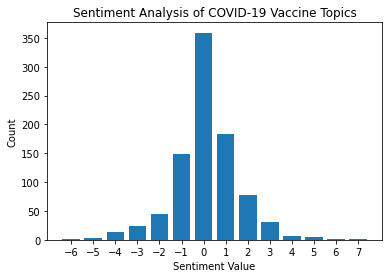

In [ ]:
### User Input
index = 0
while index < np.inf: 
    choice = input('''What do you want?
                    1. Update Data
                    2. Update Sentiment Value
                    3. View Data
                    4. Sentiment Visualization
                    5. Popularity Score of User Accounts
                    6. Reach Score of User Accounts
                    7. Exit
                    Your Input:''')
    if choice == '1':
        data = get_data(consumer_key, consumer_secret, access_token, access_token_secret, search_word, range_date)
        update_tweet(database_name, update_twitter, data)
        print('Your data have been updated!')
    if choice == '2':
        tweet_ = read_sql(database_name, read_data)
        Sentiment = sentiment_value(tweet_, pos_word, neg_word)
        update_sentiment_column(database_name, update_sentiment, Sentiment)
        print('Sentiment values have been updated!')
    if choice == '3':
        date1 = input('Start date (format: yyyy-mm-dd):')
        date2 = input('End date (format: yyyy-mm-dd):')
        record = display_data(database_name, select_data, date1, date2)
        df(record)
    if choice == '4':
        date1 = input('Start date (format: yyyy-mm-dd):')
        date2 = input('End date (format: yyyy-mm-dd):')
        record = display_data(database_name, select_data, date1, date2)
        visualization(record)
    if choice == '5':
        date1 = input('Start date (format: yyyy-mm-dd):')
        date2 = input('End date (format: yyyy-mm-dd):')
        record = display_data(database_name, select_data, date1, date2)
        vis_pop(record)
    if choice == '6':
        date1 = input('Start date (format: yyyy-mm-dd):')
        date2 = input('End date (format: yyyy-mm-dd):')
        record = display_data(database_name, select_data, date1, date2)
        vis_reach(record)
    if choice == '7':
        print('Thank you! Have a good day!')
        break